In [1]:
# https://bigquery.cloud.google.com/dataset/the-psf:pypi

%matplotlib inline

import os
import io
import json
import logging
import functools
import collections

import pandas as pd

CRED_KW = {'token', 'refresh_token', 'id_token', 'token_uri', 'client_id', 'client_secret'}

def get_credentials(scopes='https://www.googleapis.com/auth/bigquery',
                    secrets='~/client_secrets.json', storage='~/storage.json'):
    secrets, storage = map(os.path.expanduser, [secrets, storage])

    def make_credentials(filename, scopes):
        from google_auth_oauthlib.flow import InstalledAppFlow

        flow = InstalledAppFlow.from_client_secrets_file(filename, scopes)
        flow.run_local_server()
        return flow.credentials

    def load_credentials(filename, scopes):
        from google.oauth2.credentials import Credentials

        with io.open(filename, 'rb') as f:
            kwargs = json.load(f)
        kwargs['token'] = kwargs.pop('access_token')
        kwargs = {k: v for k, v in kwargs.items() if k in CRED_KW}
        return Credentials(scopes=scopes, **kwargs)

    def save_credentials(creds, filename):
        doc = {k: getattr(creds, k) for k in (CRED_KW - {'token'})}
        doc['access_token'] = creds.token
        with io.open(filename, 'w') as f:
            json.dump(doc, f)

    if os.path.exists(storage):
        creds = load_credentials(storage, scopes)
    if creds is None:
        creds = make_credentials(secrets, scopes)
        save_credentials(creds, storage)
    return creds

PROJECT_ID = 'scripting-148608'

DEBUG =  True

if DEBUG:
    log = logging.getLogger('pandas_gbq')
    log.setLevel(logging.DEBUG)
    log.addHandler(logging.StreamHandler())

read_gbq = functools.partial(pd.read_gbq, project_id=PROJECT_ID,
                             credentials=get_credentials())

In [2]:
PROJECTS = (
    'graphviz', 'features', 'concepts', 'bitsets', 'fileconfig',
    'gsheets', 'latexpages', 'dmengine', 'current', 'csv23',
)

START, END = '20190801', '20190831'

QUERY = r'''SELECT
  EXTRACT(YEAR FROM timestamp) AS year,
  EXTRACT(MONTH FROM timestamp) AS month,
  file.project AS project,
  file.version AS version,
  file.type AS type,
  country_code AS country,
  REGEXP_EXTRACT(details.python, r'^([^\.]+\.[^\.]+)') AS python,
  details.system.name AS system,
  COUNT(*) AS downloads
FROM `the-psf.pypi.downloads*`
WHERE file.project IN %r AND _TABLE_SUFFIX BETWEEN '%s' AND '%s'
GROUP BY year, month, project, version, type, country, python, system''' % (PROJECTS, START, END)

DTYPE = collections.OrderedDict([
    ('year', int),
    ('month', int),
    ('project', object),
    ('version', object),
    ('type', object),
    ('country', object),
    ('python', object),
    ('system', object),
    ('downloads', int),
])

INDEX = list(DTYPE)[:-1]

RESULT, ENCODING = 'pypi.csv', 'utf-8'

if not os.path.exists(RESULT):
    _df = read_gbq(QUERY)
    _df.to_csv(RESULT, index=False, encoding=ENCODING)

_df = pd.read_csv(RESULT, encoding=ENCODING, dtype=DTYPE)\
    .sort_values(by=INDEX).reset_index(drop=True)

_df.info()

Requesting query... 
Query running...
Job ID: cf75a11e-dadd-4a1e-9b61-892c540626f4
  Elapsed 6.73 s. Waiting...
  Elapsed 7.74 s. Waiting...
Query done.
Processed: 174.7 GB Billed: 174.7 GB
Standard price: $0.85 USD

Got 12297 rows.

Total time taken 12.56 s.
Finished at 2019-09-01 10:46:02.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12297 entries, 0 to 12296
Data columns (total 9 columns):
year         12297 non-null int32
month        12297 non-null int32
project      12297 non-null object
version      12297 non-null object
type         12297 non-null object
country      11665 non-null object
python       6425 non-null object
system       5932 non-null object
downloads    12297 non-null int32
dtypes: int32(3), object(6)
memory usage: 720.7+ KB


In [3]:
ARCHIVE = 'pypi_archive.csv'

_af = pd.read_csv(ARCHIVE, encoding=ENCODING, dtype=DTYPE)\
    .sort_values(by=INDEX).reset_index(drop=True)

_af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271132 entries, 0 to 271131
Data columns (total 9 columns):
year         271132 non-null int32
month        271132 non-null int32
project      271132 non-null object
version      271132 non-null object
type         271132 non-null object
country      257944 non-null object
python       116666 non-null object
system       106509 non-null object
downloads    271132 non-null int32
dtypes: int32(3), object(6)
memory usage: 15.5+ MB


In [4]:
COMBINED = 'pypi_archive-new.csv'

def merge_concat(dataframes, index):
    dataframes = [d.fillna('N/A').set_index(index) for d in dataframes if not d.empty]
    try:
        result = dataframes[0]
    except KeyError:
        return pd.DataFrame()
    for d in dataframes[1:]:
        old = result.loc[result.index.difference(d.index)]
        new = d.loc[d.index.difference(old.index)]
        #assert old.index.intersection(new.index).empty
        #common = result.index.intersection(new.index)
        #assert result.loc[common].equals(new.loc[common])
        result = pd.concat([old, new])
    return result.reset_index().replace('N/A', pd.np.nan).sort_values(by=index)

_cf = merge_concat([_df, _af], INDEX)
_cf.to_csv(COMBINED, index=False, encoding=ENCODING)
_cf = pd.read_csv(COMBINED, encoding=ENCODING, dtype=DTYPE)
_cf.info()

df = _cf.fillna('N/A')
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283429 entries, 0 to 283428
Data columns (total 9 columns):
year         283429 non-null int32
month        283429 non-null int32
project      283429 non-null object
version      283429 non-null object
type         283429 non-null object
country      269609 non-null object
python       123091 non-null object
system       112441 non-null object
downloads    283429 non-null int32
dtypes: int32(3), object(6)
memory usage: 16.2+ MB


,year,month,project,version,type,country,python,system,downloads
283424,2019,8,latexpages,0.6.6,sdist,TW,N/A,N/A,1
283425,2019,8,latexpages,0.6.6,sdist,US,2.7,Linux,2
283426,2019,8,latexpages,0.6.6,sdist,US,N/A,N/A,32
283427,2019,8,latexpages,0.6.6,sdist,N/A,3.6,N/A,1
283428,2019,8,latexpages,0.6.6,sdist,N/A,N/A,N/A,5


In [5]:
df.pivot_table('downloads', ['year', 'month'], 'project', aggfunc='sum', fill_value=0)

project     bitsets  concepts  csv23  current  dmengine  features  fileconfig  \
year month                                                                      
2016 6         3805      3799      0      654      1244      2286        1360   
     7         3905      3999      0      974      1413      2407        1532   
     8         4494      4505      0     1099      1737      2790        1751   
     9         3989      4158      0     1169      1658      2559        1636   
     10        3156      3002      0      776      1159      1912        1227   
     11        3376      3505      0      622      1133      2040        1188   
     12        2811      2873      0      505       931      1698        1011   
2017 1         3145      3099      0      532       866      1571         940   
     2         2981      3072      0      568      1005      1760        1077   
     3         3649      3889      0      675      1162      2063        1202   
     4         4387      4434      0      850       793      2544        1510   
     5         2946      2632      0     1140      1326      2470        2810   
     6         3001      2911      0      798      1014      1872        1661   
     7         2492      2353      0      653       874      1646        1328   
     8         2433      2415      0      574      1428      1558        1115   
     9         2431      2247      0      570       987      1619        1205   
     10        3163      3257      0      524       936      2282        1998   
     11        3305      3028      0      517       978      2394        1924   
     12        2985      3037      0      670      1192      2208        1776   
2018 1         2227      2390   1081      628       933      1698        1237   
     2         1804      1792    497      372       668      1263         968   
     3         1444      1433    264      263       506      1103         843   
     4         1504      1374    437      321       629      1121         904   
     5         1632      1760    676      421       687      1187         905   
     6         1407      1403    423      283       504       880         791   
     7         1191      1071    308      261       426       859         690   
     8         3885      3719   1012      882      1491      2640        2080   
     9         3415      3407   1011      832      1353      2426        1927   
     10        4402      4331   1077     1362      2020      2974        2645   
     11        3782      3459    810     1014      1483      2511        2005   
     12        3356      3347    860      947      1333      2236        1814   
2019 1         3499      3316    890      911      1372      2165        1746   
     2         3026      3235   1197      847      1235      2130        1784   
     3         3808      3622   1802      965      1442      2474        1978   
     4         3202      3523   1656      828      1262      2247        1842   
     5         4447      4538   1921     1050      1624      2587        2112   
     6         4268      4353   2380     1519      2116      2947        2527   
     7         4179      4284   2074     1064      1428      2301        1876   
     8         3748      3787   1644     1029      1402      2286        1957   

project     graphviz  gsheets  latexpages  
year month                                 
2016 6         23462        0        2327  
     7         27466        0        2175  
     8         27825        0        2459  
     9         34277        0        4306  
     10        31108        0        1843  
     11        32904      526        1971  
     12        36357      278        1703  
2017 1         47077      198        1464  
     2         47283      226        1854  
     3         59031      967        3395  
     4         55757      389        1699  
     5         60170      268        1351  
     6         64933      358        1637  
     7         951

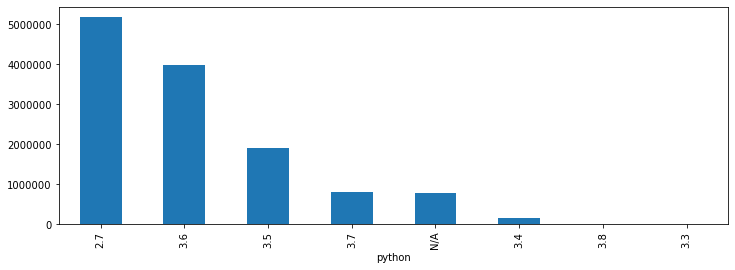

In [6]:
df.groupby('python')['downloads'].sum()\
    .sort_values(ascending=False)[:8].plot.bar(figsize=(12, 4));

In [7]:
df.groupby('python')['downloads'].sum()\
    .sort_values(ascending=False).to_frame()\
    .apply(lambda x: x / x.sum()).style.format('{:.2%}').set_uuid('6')

,downloads
python,
2.7,40.45%
3.6,31.07%
3.5,14.77%
3.7,6.25%
N/A,6.16%
3.4,1.15%
3.8,0.05%
3.3,0.04%
2.6,0.04%


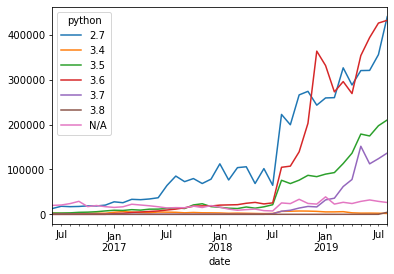

In [8]:
df.groupby(['year', 'month', 'python']).sum()\
    [lambda x: x['downloads'] > 1000].reset_index()\
    .assign(date=lambda x: pd.to_datetime(x[['year', 'month']].assign(day=1)))\
    .pivot(index='date', columns='python', values='downloads').fillna(0, downcast='infer')\
    .plot();

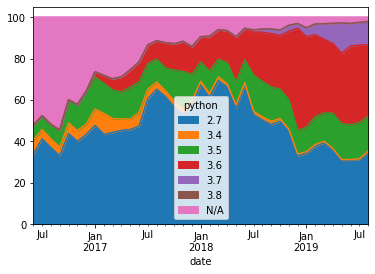

In [9]:
df.groupby(['year', 'month', 'python']).sum()\
    [lambda x: x['downloads'] > 1000].reset_index()\
    .assign(date=lambda x: pd.to_datetime(x[['year', 'month']].assign(day=1)))\
    .pivot(index='date', columns='python', values='downloads').fillna(0, downcast='infer')\
    .stack().groupby('date').transform(lambda g: 100 * g / g.sum()).unstack()\
    .plot(kind='area');

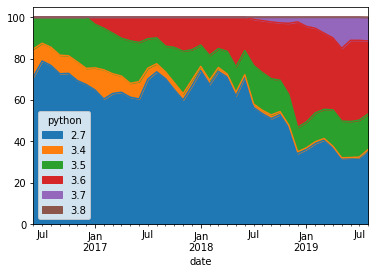

In [10]:
df.groupby(['year', 'month', 'python']).sum()\
    [lambda x: x['downloads'] > 1000].reset_index()\
    .assign(date=lambda x: pd.to_datetime(x[['year', 'month']].assign(day=1)))\
    .pivot(index='date', columns='python', values='downloads').fillna(0, downcast='infer')\
    .drop('N/A', axis=1).stack().groupby('date').transform(lambda g: 100 * g / g.sum()).unstack()\
    .plot(kind='area');

In [11]:
gf = df[df['project'] == 'graphviz'].drop('project', axis=1)
gf.tail()

,year,month,version,type,country,python,system,downloads
282486,2019,8,0.9,sdist,TW,N/A,N/A,2
282487,2019,8,0.9,sdist,US,2.7,Darwin,1
282488,2019,8,0.9,sdist,US,2.7,Linux,1
282489,2019,8,0.9,sdist,US,N/A,N/A,16
282490,2019,8,0.9,sdist,N/A,N/A,N/A,5


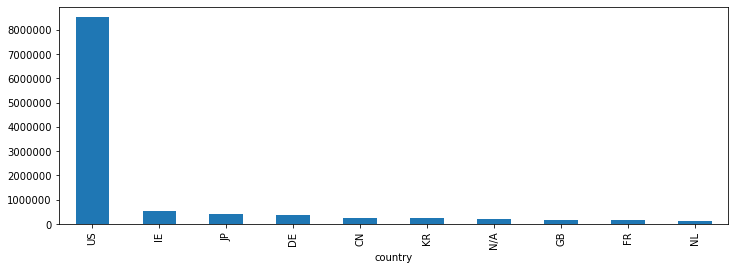

In [12]:
gf.groupby('country')['downloads'].sum().sort_values(ascending=False)[:10].plot.bar(figsize=(12, 4));

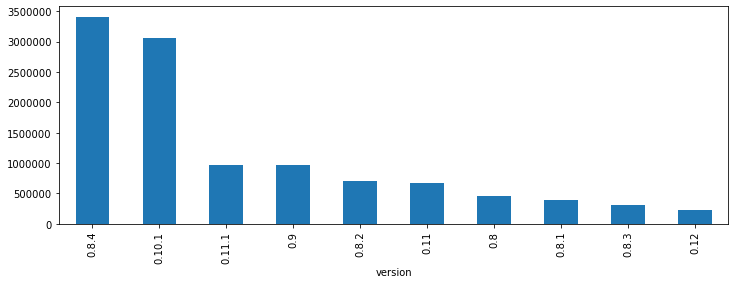

In [13]:
gf.groupby('version')['downloads'].sum().sort_values(ascending=False)[:10].plot.bar(figsize=(12, 4));

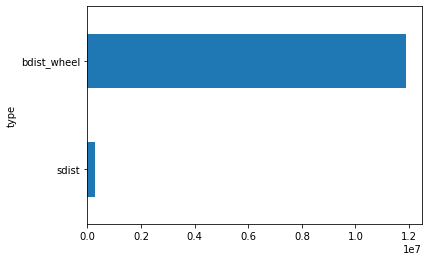

In [14]:
gf.groupby('type')['downloads'].sum().sort_values().plot.barh();

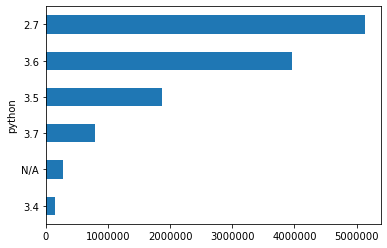

In [15]:
gf.groupby('python')['downloads'].sum().sort_values()[-6:].plot.barh();

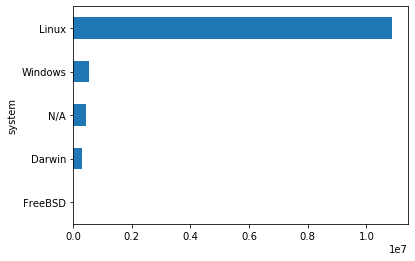

In [16]:
gf.groupby('system')['downloads'].sum().sort_values()[-5:].plot.barh();